In [1]:
import os
import random
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import torch

class ImageFolderSplitter(Dataset):
    def __init__(self, base_dir, train_size=20, test_size=5, split='train', transform=None):
        """
        :param base_dir: Directory where all the image subfolders are located.
        :param train_size: Number of images to use for training from each folder.
        :param test_size: Number of images to use for testing from each folder.
        :param split: Either 'train' or 'test', decides which split to load.
        :param transform: Optional transform to be applied on a sample.
        """
        self.base_dir = base_dir
        self.train_size = train_size
        self.test_size = test_size
        self.split = split
        self.transform = transform

        # List all subfolders (each folder is a class)
        self.subfolders = [f for f in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, f))]

        self.image_paths = []
        for folder in self.subfolders:
            folder_path = os.path.join(base_dir, folder)

            # Get all image files in the current folder (assuming images are .jpg, .png, etc.)
            images = [f for f in os.listdir(folder_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
            random.shuffle(images)

            if self.split == 'train':
                selected_images = images[:self.train_size]
            elif self.split == 'test':
                selected_images = images[self.train_size:self.train_size+self.test_size]
            else:
                raise ValueError("split must be 'train' or 'test'")

            # Append the paths of selected images
            for image in selected_images:
                image_path = os.path.join(folder_path, image)
                self.image_paths.append((image_path, folder))

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path, label = self.image_paths[idx]
        image = Image.open(image_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label

# Set up transformations
transform = transforms.Compose([
    transforms.Resize((512,512)),  # Resize to a smaller size for efficiency
    transforms.ToTensor(),
])

# Set up Dataset
base_dir = 'data/images/Images'  # Path to the base folder containing subfolders for classes
train_dataset = ImageFolderSplitter(base_dir=base_dir, split='train', transform=transform)
test_dataset = ImageFolderSplitter(base_dir=base_dir, split='test', transform=transform)

# Set up DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False)


/home/shu/.conda/envs/inf502/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder

class VAE(nn.Module):
    def __init__(self, latent_dim=128):
        super(VAE, self).__init__()
        
        self.latent_dim = latent_dim
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1),  # 3x128x128 -> 32x64x64
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),  # 32x64x64 -> 64x32x32
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),  # 64x32x32 -> 128x16x16
            nn.ReLU(),
        )
        
        # Calculate the flattened size of the output from the encoder (feature map size)
        dummy_input = torch.zeros(1, 3, 512,512)  # Batch size 1, 3 channels, 128x128 image
        with torch.no_grad():
            feature_map = self.encoder(dummy_input)  # Pass through the encoder
        flattened_size = feature_map.numel()  # Get the total number of elements in the feature map
        
        # Latent space (mu and logvar for variational distribution)
        self.fc_mu = nn.Linear(flattened_size, latent_dim)
        self.fc_logvar = nn.Linear(flattened_size, latent_dim)
        
        # Decoder
        self.fc_dec = nn.Linear(latent_dim, flattened_size)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),  # 128x8x8 -> 64x16x16
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),  # 64x16x16 -> 32x32x32
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, kernel_size=3, stride=2, padding=1, output_padding=1),  # 32x32x32 -> 3x64x64
            nn.Sigmoid()  # Sigmoid to get values between 0 and 1
        )
    
    def encode(self, x):
        h = self.encoder(x)
        h = h.view(h.size(0), -1)  # Flatten the output
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h = self.fc_dec(z)
        
        # Dynamically reshape based on flattened size
        h = h.view(h.size(0), 128, 64,64)  # Adjust based on the encoder output size
        return self.decoder(h)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


In [3]:
def loss_function(recon_x, x, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')
    
    # KL divergence between the learned distribution and a standard normal
    # KL = -0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    # The factor of 0.5 comes from integrating over the continuous space
    # where the variance is expected to be 1.
    # -0.5 * sum(1 + log(var) - mean^2 - var)
    # 'sum' reduction computes the total for the batch
    # Make sure your input images are normalized to [0, 1] to use BCE
    # If using different loss formulations like MSE, this might need adjustments
    MSE_loss = nn.MSELoss(reduction='sum')
    recon_loss = MSE_loss(recon_x.view(-1, 3 * 64 * 64), x.view(-1, 3 * 64 * 64))
    
    # Calculate KL divergence loss
    KL_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    return recon_loss + KL_divergence


In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set up dataset and dataloaders
batch_size = 8

model = VAE(latent_dim=128).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for batch_idx, (data, _) in enumerate(train_dataloader):
        data = data.to(device)
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        recon_batch, mu, logvar = model(data)
        
        # Compute the loss
        loss = loss_function(recon_batch, data, mu, logvar)
        
        # Backward pass
        loss.backward()
        
        # Update weights
        optimizer.step()
        
        train_loss += loss.item()
        
        if batch_idx % 5 == 0:
            print(f"Epoch [{epoch}/{num_epochs}], Batch [{batch_idx}/{len(train_dataloader)}], Loss: {loss.item()}")

    print(f"Epoch [{epoch}/{num_epochs}] Training Loss: {train_loss / len(train_dataloader)}")

    # Test the model
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for data, _ in test_dataloader:
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            loss = loss_function(recon_batch, data, mu, logvar)
            test_loss += loss.item()

    print(f"Epoch [{epoch}/{num_epochs}] Test Loss: {test_loss / len(test_dataloader)}")


Epoch [0/10], Batch [0/300], Loss: 361278.9375
Epoch [0/10], Batch [5/300], Loss: 431585.4375
Epoch [0/10], Batch [10/300], Loss: 548867.3125


KeyboardInterrupt: 

In [7]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# Function to perform the interpolation
def interpolate_and_display(model, img1, img2, num_steps=10):
    # Move the model and images to the correct device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    img1 = img1.to(device).unsqueeze(0)  # Unsqueeze to add a batch dimension
    img2 = img2.to(device).unsqueeze(0)  # Unsqueeze to add a batch dimension

    # Encode the two images to get their latent vectors
    mu1, logvar1 = model.encode(img1)
    mu2, logvar2 = model.encode(img2)

    # Reparameterize to get the latent vectors (z1 and z2)
    z1 = model.reparameterize(mu1, logvar1)
    z2 = model.reparameterize(mu2, logvar2)

    # Interpolate between z1 and z2
    interpolated_images = []
    interpolated_images.append(img1.cpu().detach().numpy())
    for alpha in np.linspace(0, 1, num_steps):
        z_interpolated = (1 - alpha) * z1 + alpha * z2  # Linear interpolation
        recon_image = model.decode(z_interpolated)  # Decode the interpolated latent vector
        interpolated_images.append(recon_image.cpu().detach().numpy())

    # Plot the interpolated images
    fig, axes = plt.subplots(1, num_steps, figsize=(15, 3))
    for i, ax in enumerate(axes):
        ax.imshow(np.transpose(interpolated_images[i][0], (1, 2, 0)))  # Convert from (C, H, W) to (H, W, C)
        ax.axis('off')
    plt.show()

# Example of how to use the function after training
# Assume you have your trained model and some sample images



In [7]:
torch.save(model.state_dict(), 'vae_model.pth')

In [5]:
vae=VAE(latent_dim=128)
vae.load_state_dict(torch.load('vae_model.pth'))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vae.to(device)
vae.eval()
print(vae)

VAE(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
  )
  (fc_mu): Linear(in_features=524288, out_features=128, bias=True)
  (fc_logvar): Linear(in_features=524288, out_features=128, bias=True)
  (fc_dec): Linear(in_features=128, out_features=524288, bias=True)
  (decoder): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(32, 3, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (5): Sigmoid()
  )
)


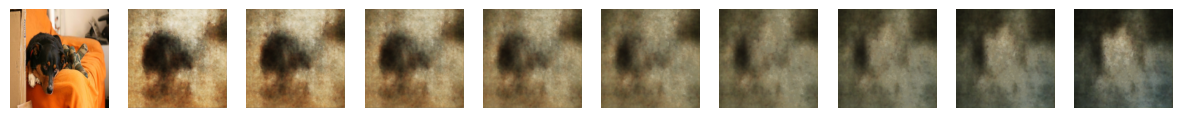

In [8]:
img1, _ = next(iter(train_dataloader))  # Example: first image from the train dataset
img2, _ = next(iter(train_dataloader))  # Example: second image from the train dataset

# Perform interpolation and display
interpolate_and_display(vae, img1[0], img2[0], num_steps=10)

In [14]:
import cv2
def sharpen_image(image):
    """ Apply a simple sharpening filter to the image """
    kernel = np.array([[0, -1, 0], [-1, 5,-1], [0, -1, 0]])
    return cv2.filter2D(image, -1, kernel)

def denoise_image(image):
    """ Applies Non-Local Means Denoising to reduce noise. """
    return cv2.fastNlMeansDenoisingColored(image, None, 10, 10, 7, 21)  # Corrected args



In [10]:
from realesrgan import RealESRGANer
from basicsr.archs.rrdbnet_arch import RRDBNet
import cv2
import numpy as np

# Load Real-ESRGAN model
model = RRDBNet(num_in_ch=3, num_out_ch=3, num_feat=64, num_block=23, num_grow_ch=32)
upsampler = RealESRGANer(scale=4, model_path='weights/RealESRGAN_x4plus.pth', model=model, tile=200)


def enhance_image(image):
    """Enhances an image using ESRGAN super-resolution."""
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)  # Convert to BGR for ESRGAN
    sr_image, _ = upsampler.enhance(image, outscale=4)  # 4x upscale
    sr_image = cv2.cvtColor(sr_image, cv2.COLOR_BGR2RGB)  # Convert back to RGB
    return sr_image

/home/shu/.conda/envs/inf502/lib/python3.9/site-packages/torchvision/transforms/functional_tensor.py:5: UserWarning: The torchvision.transforms.functional_tensor module is deprecated in 0.15 and will be **removed in 0.17**. Please don't rely on it. You probably just need to use APIs in torchvision.transforms.functional or in torchvision.transforms.v2.functional.
  warnings.warn(


In [20]:
def slerp(val, z1, z2):
    """Spherical linear interpolation for latent vectors."""
    z1, z2 = z1.squeeze(0).cpu().detach().numpy(), z2.squeeze(0).cpu().detach().numpy()  
    dot_product = np.dot(z1, z2) / (np.linalg.norm(z1) * np.linalg.norm(z2))
    dot_product = np.clip(dot_product, -1.0, 1.0)  
    omega = np.arccos(dot_product)
    so = np.sin(omega)
    
    z_interp = (np.sin((1 - val) * omega) / so) * z1 + (np.sin(val * omega) / so) * z2  
    return torch.tensor(z_interp, dtype=torch.float32, device="cuda").unsqueeze(0)  # Restore batch dim


In [17]:
import torch
import numpy as np

from torchvision import transforms
import matplotlib.pyplot as plt
from PIL import Image
import os
import torch.nn.functional as F
def generate_interpolated_video(model, output_folder="outputs/keyframes", output_video="outputs/output.avi", step=100, device="cuda"):
    """ Loads key frames, generates interpolated frames using VAE, and creates a video. """
    frames = []
    frame_files = sorted(os.listdir(output_folder))  # Ensure correct order

    transform = transforms.ToTensor()

    # Load key frames
    for i in range(len(frame_files) - 1):
        img1 = Image.open(os.path.join(output_folder, frame_files[i]))
        img2 = Image.open(os.path.join(output_folder, frame_files[i + 1]))

        # Convert to tensors
        current_frame = transform(img1).unsqueeze(0).to(device)
        next_frame = transform(img2).unsqueeze(0).to(device)

        # Encode frames into latent space
        mu1, logvar1 = model.encode(current_frame)
        mu2, logvar2 = model.encode(next_frame)
        z1 = model.reparameterize(mu1, logvar1)
        z2 = model.reparameterize(mu2, logvar2)
        # Interpolate in latent space
        for t in range(step + 1):
            alpha = t / step  # Interpolation factor
            interpolated_mu = mu1 * (1 - alpha) + mu2 * alpha
            interpolated_logvar = logvar1 * (1 - alpha) + logvar2 * alpha
            #interpolated_z = slerp(alpha, z1, z2).to(device)
            # Sample latent vector
            z = model.reparameterize(interpolated_mu, interpolated_logvar)

            # Decode to get the interpolated frame
            reconstructed_frame = model.decode(z)
            frame_np = reconstructed_frame.squeeze().cpu().detach().numpy().transpose(1, 2, 0)
            frame_np = np.clip(frame_np * 255, 0, 255).astype(np.uint8)
            frame_np = sharpen_image(frame_np)
            #frame_np = enhance_image(frame_np)
            # plt.imshow(frame_np)
            # plt.axis('off')
            # plt.show(block=False)
            # plt.pause(0.1)
            frames.append(frame_np)

    # Save the video
    height, width, _ = frames[0].shape
    fourcc = cv2.VideoWriter_fourcc(*"XVID")
    out = cv2.VideoWriter(output_video, fourcc, 10, (width, height))

    for frame in frames:
        out.write(cv2.cvtColor(frame, cv2.COLOR_RGB2BGR))

    out.release()
    print(f"Video saved as {output_video}")

In [18]:
generate_interpolated_video(model=vae)

Video saved as outputs/output.avi
